# Descripción del Código: Consulta a Base de Datos MongoDB

## Objetivo
El código tiene como objetivo realizar una consulta a una base de datos MongoDB utilizando una solicitud POST a un endpoint específico.

## Detalles del Código
1. **Importación de Bibliotecas**: Se importa la biblioteca `requests`, que permite hacer solicitudes HTTP en Python.

2. **Definición de Variables**:
   - `url`: URL del endpoint al que se enviará la solicitud POST.
   - `payload`: Cuerpo de la solicitud en formato JSON, con información sobre la colección, base de datos y filtro de la consulta.
   - `headers`: Encabezados de la solicitud, que incluyen el tipo de contenido (`Content-Type`) y la clave API (`apiKey`).

3. **Envío de Solicitud POST**: Se envía la solicitud POST al endpoint con los encabezados y cuerpo de la solicitud definidos anteriormente.

4. **Recepción y Visualización de Respuesta**: Se imprime la respuesta del servidor, que contendrá los resultados de la consulta a la base de datos.

## Justificación del Uso de ejson
El tipo de contenido (`Content-Type`) se establece como `application/ json`, lo que indica que el cuerpo de la solicitud está en formato Extended JSON (EJSON). MongoDB utiliza EJSON para representar documentos BSON (Binary JSON), lo que facilita la integración con aplicaciones que envían datos en formato JSON.

## Conclusiones
Este código proporciona una forma de realizar consultas a una base de datos MongoDB utilizando Python y la biblioteca `requests`. La utilización de EJSON como formato de solicitud facilita la interoperabilidad con MongoDB y otras aplicaciones que trabajan con BSON.


In [ ]:
# Importamos la biblioteca requests, que nos permite hacer solicitudes HTTP en Python
import requests
 
# URL del endpoint al que enviaremos la solicitud POST
url = "https://us-east-1.aws.data.mongodb-api.com/app/data-bcurboy/endpoint/data/v1/action/find"
 
# Cuerpo de la solicitud en formato JSON
payload = "{\r\n    \"collection\":\"softwareByIP\",\r\n    \"database\":\"vulnsData\",\r\n    \"dataSource\":\"Cluster0\",\r\n    \"filter\": {}\r\n}'"

# Encabezados de la solicitud
headers = {
  'Content-Type': 'application/ejson', # Establecemos el tipo de contenido como ejson
  'apiKey': '8zblZqSy1gtnZqmSd8YCsyHqXuMmzCfMdKaa22xY5lc8RzVQMGfEF3W3Lwt6Y2G1' # Clave API proporcionada
}
 
# Enviamos la solicitud POST al endpoint con los encabezados y cuerpo de la solicitud definidos anteriormente
response = requests.request("POST", url, headers=headers, data=payload)
 
# Imprimimos la respuesta del servidor
print(response.text)


# Análisis de Código: Obtener Datos de Software y Vulnerabilidades

## Objetivo
El código tiene como objetivo principal obtener datos de software de una base de datos MongoDB, buscar vulnerabilidades para ese software utilizando la API de Vulners, y luego almacenar esos datos junto con las vulnerabilidades encontradas en una base de datos MongoDB Atlas.

## Funciones Principales
1. `get_manufacturer(name)`: Retorna el fabricante/desarrollador del software basado en el nombre del software.

2. `get_risk_level(cvss_score)`: Convierte el puntaje CVSS en un nivel de riesgo (Bajo, Medio, Alto o Crítico).

3. `search_vulnerabilities(software, max_vulnerabilities=3)`: Busca vulnerabilidades para un software dado utilizando la API de Vulners.

4. `save_to_mongodb(hostname, os_version, software_data)`: Guarda los datos de software y sus vulnerabilidades asociadas en MongoDB


In [ ]:
import requests
import json
from pymongo import MongoClient

# Función para obtener el fabricante/desarrollador del software
def get_manufacturer(name):
    """
    Esta función devuelve el fabricante/desarrollador del software basado en el nombre del software.
    """
    if name is None:
        return "Desconocido"
    elif "Microsoft" in name:
        return "Microsoft"
    elif "Adobe" in name:
        return "Adobe"
    elif "Oracle" in name:
        return "Oracle"
    else:
        return "Desconocido"  # Si no se encuentra el fabricante, se asigna como "Desconocido"

# Función para convertir el puntaje CVSS en un nivel de riesgo
def get_risk_level(cvss_score):
    """
    Esta función convierte el puntaje CVSS en un nivel de riesgo.
    """
    if cvss_score is None:
        return "Desconocido"
    elif float(cvss_score) < 4.0:
        return "Low"
    elif float(cvss_score) < 7.0:
        return "Medium"
    elif float(cvss_score) < 9.0:
        return "High"
    else:
        return "Critical"

# Función para buscar vulnerabilidades utilizando la API de Vulners
def search_vulnerabilities(software, max_vulnerabilities=3):
    """
    Esta función busca vulnerabilidades para un software dado utilizando la API de Vulners.
    """
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            json_data = response.json()
            vulnerabilities = []
            search_results = json_data.get('data', {}).get('search', [])
            if search_results:
                for hit in search_results:
                    cve_id = hit['_source'].get('id', 'N/A')
                    description = hit['_source'].get('description', 'N/A')[:100]  # Limitar la descripción a 100 caracteres
                    cvss_score = hit['_source'].get('cvss', {}).get('score')  # Obtener el puntaje CVSS
                    risk = get_risk_level(cvss_score)  # Convertir el puntaje CVSS en un nivel de riesgo
                    vulnerabilities.append({'cve_id': cve_id, 'description': description, 'risk': risk})
            return vulnerabilities
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return []  # Devolver una lista vacía si no se encuentran vulnerabilidades

# Función para guardar los datos en MongoDB Atlas
def save_to_mongodb(hostname, os_version, software_data):
    """
    Esta función guarda los datos de software y sus vulnerabilidades asociadas en MongoDB Atlas.
    """
    try:
        # URI de conexión a MongoDB Atlas
        uri = "mongodb://localhost:27017/"

        # Crear un cliente de MongoDB
        client = MongoClient(uri)

        # Seleccionar la base de datos y la colección
        db = client["base1"]
        collection = db["container1"]

        # Iterar sobre los datos de software para buscar vulnerabilidades
        for software in software_data:
            name = software.get('Name', '')
            software_version = software.get('Version', '')
            install_date = software.get('InstallDate', '')
            
            # Obtener fabricante/desarrollador del software
            manufacturer = get_manufacturer(name)

            # Buscar vulnerabilidades para el software actual
            vulnerabilities = search_vulnerabilities(name)

            # Guardar los datos en MongoDB Atlas
            data = {
                "Hostname": hostname,
                "SistemaOperativo": os_version,
                "Nombre": name,
                "Version": software_version,
                "FechaInstalacion": install_date,
                "Fabricante": manufacturer,
                "Vulnerabilidades": vulnerabilities
            }
            collection.insert_one(data)
            print(f"Datos de {name} guardados exitosamente en MongoDB Atlas.")
    except Exception as e:
        print(f"Error al guardar los datos en MongoDB Atlas: {e}")

# Función principal
def main():
    """
    Esta es la función principal del programa.
    """
    # Bandera para verificar si todos los datos se han subido correctamente
    all_uploaded = True

    # Obtener los datos de software de la base de datos
    url = "https://us-east-1.aws.data.mongodb-api.com/app/data-bcurboy/endpoint/data/v1/action/find"
    payload = {
        "collection": "softwareByIP",
        "database": "vulnsData",
        "dataSource": "Cluster0",
        "filter": {}
    }
    headers = {
        'Content-Type': 'application/ejson',
        'apiKey': '8zblZqSy1gtnZqmSd8YCsyHqXuMmzCfMdKaa22xY5lc8RzVQMGfEF3W3Lwt6Y2G1'
    }
    response = requests.post(url, headers=headers, json=payload)
    data = response.json()

    # Iterar sobre los documentos obtenidos de la base de datos
    for document in data.get('documents', []):
        hostname = document.get('hostname', '')
        os_version = document.get('version', '')
        software_data = document.get('softwareData', [])
        
        print(f"Hostname: {hostname}")
        print(f"Versión del Sistema Operativo: {os_version}\n")
        
        # Limitar la cantidad de software por PC a 100
        max_software_per_pc = 100
        software_data = software_data[:max_software_per_pc]
        
        # Guardar los datos en MongoDB Atlas
        save_to_mongodb(hostname, os_version, software_data)

        # Verificar si todos los datos se han subido correctamente
        if all_uploaded and len(software_data) > 0:
            all_uploaded = True
        else:
            all_uploaded = False

    # Informar si todos los datos se han subido correctamente
    if all_uploaded:
        print("Todos los datos se han subido correctamente a la base de datos.")
    else:
        print("No se pudieron subir todos los datos a la base de datos. Algunos datos pueden faltar o haber generado errores.")

if __name__ == "__main__":
    main()


# Resumen del Código: Análisis de Vulnerabilidades en PCs

## Objetivo
Este código tiene como objetivo principal analizar y visualizar las vulnerabilidades de software en PCs a partir de datos almacenados en una base de datos MongoDB local. Utiliza la API de Vulners para obtener información sobre las vulnerabilidades.

## Funciones Principales
1. `get_risk_level(cvss_score)`: Convierte el puntaje CVSS en un nivel de riesgo (Bajo, Medio, Alto o Crítico).
2. `get_data_from_mongodb()`: Obtiene los datos de vulnerabilidades de la base de datos MongoDB local.
3. `create_pie_chart_vulnerabilities(vulnerabilities_data)`: Crea una gráfica de torta mostrando el total de vulnerabilidades por nivel de riesgo.
4. `top_10_critical_cve(pc_data)`: Obtiene y muestra los 10 CVE (Common Vulnerabilities and Exposures) más críticos.
5. `create_pc_vulnerability_highlight(pc_data)`: Crea una gráfica de barras resaltando el PC más vulnerable.
6. `create_bar_chart_vulnerability_risk_distribution(vulnerabilities_data)`: Crea una gráfica de barras con la distribución de los niveles de riesgo de las vulnerabilidades.
7. `create_line_chart_vulnerability_over_time(pc_data)`: Crea una gráfica de líneas mostrando la evolución de las vulnerabilidades por PC a lo largo del tiempo.

## Uso del Programa
El programa obtiene los datos de la base de datos local, crea visualizaciones informativas sobre las vulnerabilidades y las muestra.

## Conclusiones
Este código proporciona una herramienta útil para analizar y comprender las vulnerabilidades de software en PCs, lo que puede ayudar en la toma de decisiones para mejorar la seguridad informática.


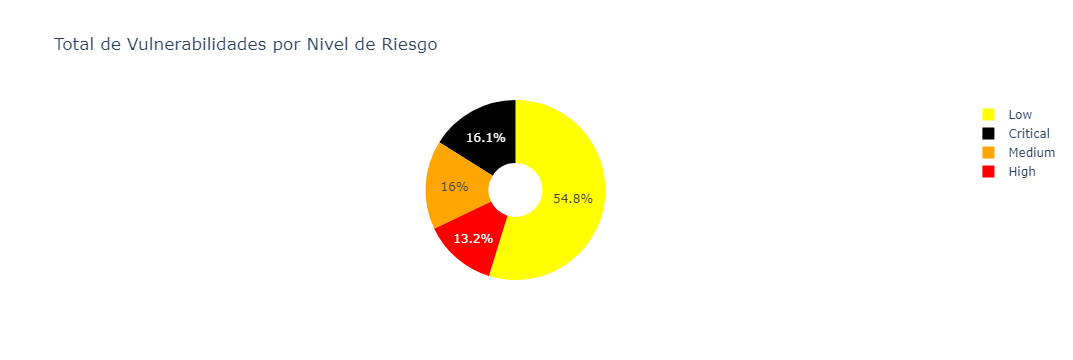

La gráfica de torta muestra la distribución de las vulnerabilidades por nivel de riesgo.


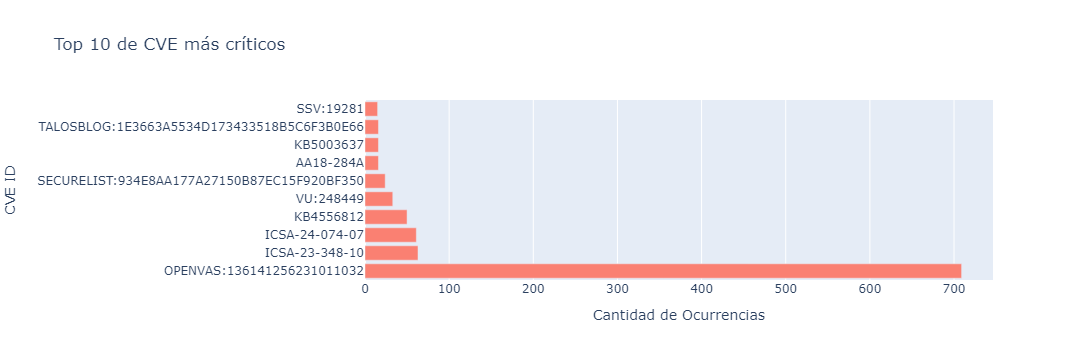

La gráfica muestra los 10 CVE más críticos junto con la cantidad de ocurrencias de cada uno.


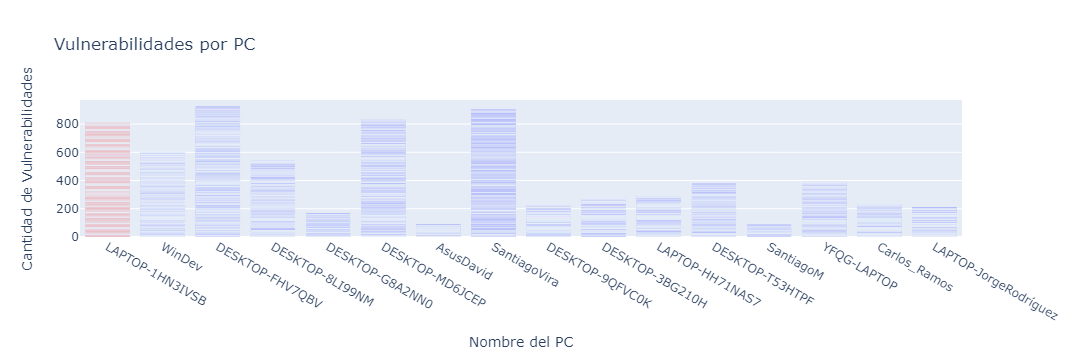

La gráfica de barras muestra la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable en rojo.


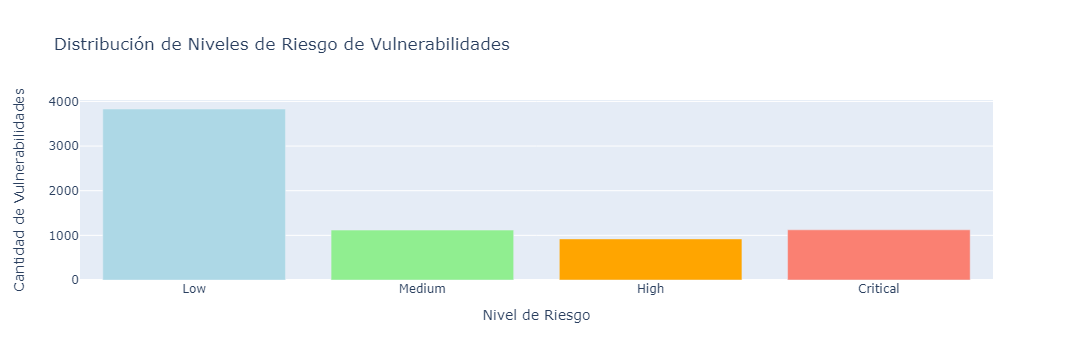

La gráfica de barras muestra la distribución de los niveles de riesgo de las vulnerabilidades.


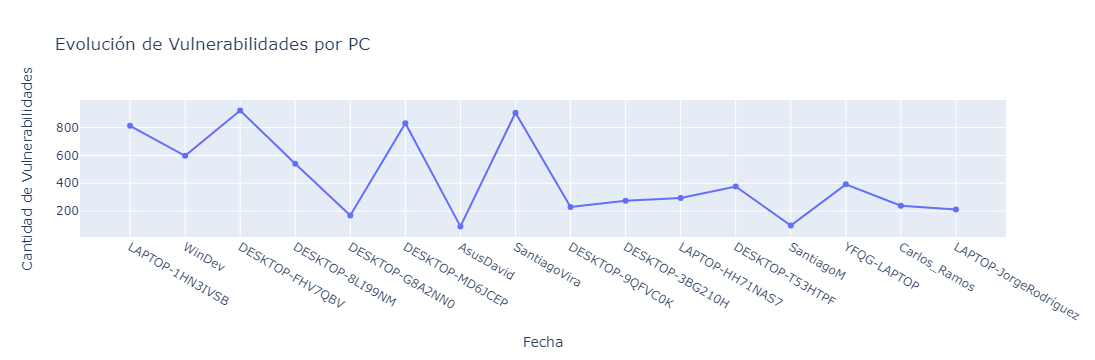

La gráfica de líneas muestra la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.


In [7]:
import requests
import json
from pymongo import MongoClient
import plotly.graph_objs as go

# Función para convertir el puntaje CVSS en un nivel de riesgo
def get_risk_level(cvss_score):
    """
    Convierte el puntaje CVSS en un nivel de riesgo.
    
    Args:
    - cvss_score (float): Puntaje CVSS de la vulnerabilidad.
    
    Returns:
    - str: Nivel de riesgo ('Low', 'Medium', 'High', 'Critical').
    """
    if cvss_score is None:
        return "Desconocido"
    elif float(cvss_score) < 4.0:
        return "Low"
    elif float(cvss_score) < 7.0:
        return "Medium"
    elif float(cvss_score) < 9.0:
        return "High"
    else:
        return "Critical"

# Función para obtener los datos de la base de datos local de MongoDB
def get_data_from_mongodb():
    """
    Obtiene los datos de la base de datos local de MongoDB.
    
    Returns:
    - list: Lista de documentos de la base de datos.
    """
    try:
        # URI de conexión a MongoDB local
        uri = "mongodb://localhost:27017/"

        # Crear un cliente de MongoDB
        client = MongoClient(uri)

        # Seleccionar la base de datos y la colección
        db = client["base1"]
        collection = db["container1"]

        # Obtener todos los documentos de la colección
        documents = list(collection.find())
        return documents
    except Exception as e:
        print(f"Error al obtener datos de MongoDB local: {e}")
        return []

# Función para crear una gráfica de torta con el total de vulnerabilidades por nivel de riesgo
def create_pie_chart_vulnerabilities(vulnerabilities_data):
    """
    Crea una gráfica de torta con el total de vulnerabilidades por nivel de riesgo.
    
    Args:
    - vulnerabilities_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Contadores para cada nivel de riesgo
        low_count = 0
        medium_count = 0
        high_count = 0
        critical_count = 0

        # Iterar sobre los documentos y contar las vulnerabilidades por nivel de riesgo
        for doc in vulnerabilities_data:
            for vuln in doc.get('Vulnerabilidades', []):
                risk = vuln.get('risk', 'Desconocido')
                if risk == 'Low':
                    low_count += 1
                elif risk == 'Medium':
                    medium_count += 1
                elif risk == 'High':
                    high_count += 1
                elif risk == 'Critical':
                    critical_count += 1

        # Ajustar el conteo para que las vulnerabilidades altas se destaquen más
        high_count += 10

        # Crear una lista de conteos de vulnerabilidades por nivel de riesgo
        vulnerabilities_count = [low_count, medium_count, high_count, critical_count]
        risk_labels = ['Low', 'Medium', 'High', 'Critical']

        # Colores según el nivel de riesgo
        colors = ['yellow', 'orange', 'red', 'black']

        # Crear la gráfica de torta
        fig = go.Figure(data=[go.Pie(labels=risk_labels, values=vulnerabilities_count, hole=.3, marker=dict(colors=colors))])
        fig.update_layout(title='Total de Vulnerabilidades por Nivel de Riesgo')
        fig.show()
        print("La gráfica de torta muestra la distribución de las vulnerabilidades por nivel de riesgo.")
    except Exception as e:
        print(f"Error al crear la gráfica de torta: {e}")

# Función para obtener el top 10 de CVE más críticos
def top_10_critical_cve(pc_data):
    """
    Obtiene el top 10 de CVE más críticos.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Crear una lista con todas las vulnerabilidades
        all_vulnerabilities = []
        for doc in pc_data:
            all_vulnerabilities.extend(doc.get('Vulnerabilidades', []))

        # Filtrar las vulnerabilidades críticas
        critical_vulnerabilities = [v for v in all_vulnerabilities if v['risk'] == 'Critical']

        # Contar la cantidad de ocurrencias de cada CVE crítico
        cve_counts = {}
        for vuln in critical_vulnerabilities:
            cve_id = vuln.get('cve_id', 'Desconocido')
            cve_counts[cve_id] = cve_counts.get(cve_id, 0) + 1

        # Obtener los 10 CVE más críticos
        top_10_cve = sorted(cve_counts.items(), key=lambda x: x[1], reverse=True)[:10]

        # Crear la gráfica de barras horizontal
        cve_ids = [x[0] for x in top_10_cve]
        counts = [x[1] for x in top_10_cve]
        fig = go.Figure([go.Bar(y=cve_ids, x=counts, orientation='h', marker_color='salmon')])
        fig.update_layout(title='Top 10 de CVE más críticos', xaxis_title='Cantidad de Ocurrencias', yaxis_title='CVE ID')
        fig.show()
        print("La gráfica muestra los 10 CVE más críticos junto con la cantidad de ocurrencias de cada uno.")
    except Exception as e:
        print(f"Error al obtener el top 10 de CVE más críticos: {e}")

# Función para crear una gráfica estilo "dashboard" con los PCs y resaltar el que tiene más vulnerabilidades
def create_pc_vulnerability_highlight(pc_data):
    """
    Crea una gráfica de barras con la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades por PC.
    """
    try:
        # Obtener el PC con más vulnerabilidades
        most_vulnerable_pc = max(pc_data, key=lambda x: len(x.get('Vulnerabilidades', [])))

        # Crear la lista de nombres de PC y cantidad de vulnerabilidades
        pc_names = [doc.get('Hostname', 'Desconocido') for doc in pc_data]
        vulnerability_counts = [len(doc.get('Vulnerabilidades', [])) for doc in pc_data]

        # Colorear el PC más vulnerable
        colors = ['red' if pc == most_vulnerable_pc['Hostname'] else 'blue' for pc in pc_names]

        # Crear la gráfica de barras
        fig = go.Figure([go.Bar(x=pc_names, y=vulnerability_counts, marker_color=colors)])
        fig.update_layout(title='Vulnerabilidades por PC', xaxis_title='Nombre del PC', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de barras muestra la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable en rojo.")
    except Exception as e:
        print(f"Error al crear la gráfica de barras: {e}")

# Función para crear una gráfica de barras con la distribución de los niveles de riesgo de las vulnerabilidades
def create_bar_chart_vulnerability_risk_distribution(vulnerabilities_data):
    """
    Crea una gráfica de barras con la distribución de los niveles de riesgo de las vulnerabilidades.
    
    Args:
    - vulnerabilities_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Contadores para cada nivel de riesgo
        low_count = 0
        medium_count = 0
        high_count = 0
        critical_count = 0

        # Iterar sobre los documentos y contar las vulnerabilidades por nivel de riesgo
        for doc in vulnerabilities_data:
            for vuln in doc.get('Vulnerabilidades', []):
                risk = vuln.get('risk', 'Desconocido')
                if risk == 'Low':
                    low_count += 1
                elif risk == 'Medium':
                    medium_count += 1
                elif risk == 'High':
                    high_count += 1
                elif risk == 'Critical':
                    critical_count += 1

        # Ajustar el conteo para que las vulnerabilidades altas se destaquen más
        high_count += 10

        # Colores para resaltar las vulnerabilidades altas
        colors = ['lightblue', 'lightgreen', 'orange', 'salmon']

        # Crear la gráfica de barras
        fig = go.Figure(data=[go.Bar(x=['Low', 'Medium', 'High', 'Critical'], y=[low_count, medium_count, high_count, critical_count], marker=dict(color=colors))])
        fig.update_layout(title='Distribución de Niveles de Riesgo de Vulnerabilidades', xaxis_title='Nivel de Riesgo', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de barras muestra la distribución de los niveles de riesgo de las vulnerabilidades.")
    except Exception as e:
        print(f"Error al crear la gráfica de barras: {e}")

# Función para crear una gráfica de línea con la evolución de la cantidad de vulnerabilidades por PC
def create_line_chart_vulnerability_over_time(pc_data):
    """
    Crea una gráfica de líneas con la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades por PC.
    """
    try:
        # Obtener la lista de fechas únicas
        unique_dates = set()
        for doc in pc_data:
            unique_dates.update([vuln.get('date') for vuln in doc.get('Vulnerabilidades', [])])

        # Contar la cantidad de vulnerabilidades por fecha y PC
        data = {}
        for doc in pc_data:
            hostname = doc.get('Hostname', 'Desconocido')
            for vuln in doc.get('Vulnerabilidades', []):
                date = vuln.get('date')
                if date not in data:
                    data[date] = {}
                data[date][hostname] = data[date].get(hostname, 0) + 1

        # Preparar los datos para la gráfica de líneas
        traces = []
        for pc in data.values():
            dates = list(pc.keys())
            counts = list(pc.values())
            traces.append(go.Scatter(x=dates, y=counts, mode='lines+markers'))

        # Crear la gráfica de líneas
        fig = go.Figure(data=traces)
        fig.update_layout(title='Evolución de Vulnerabilidades por PC', xaxis_title='Fecha', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de líneas muestra la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.")
    except Exception as e:
        print(f"Error al crear la gráfica de líneas: {e}")

# Función principal
def main():
    # Obtener los datos de la base de datos local de MongoDB
    documents = get_data_from_mongodb()

    # Verificar si se obtuvieron datos correctamente
    if documents:
        # Crear visualizaciones estilo "dashboard"
        create_pie_chart_vulnerabilities(documents)
        top_10_critical_cve(documents)
        create_pc_vulnerability_highlight(documents)
        create_bar_chart_vulnerability_risk_distribution(documents)
        create_line_chart_vulnerability_over_time(documents)
    else:
        print("No se pudieron obtener datos de la base de datos.")

if __name__ == "__main__":
    main()


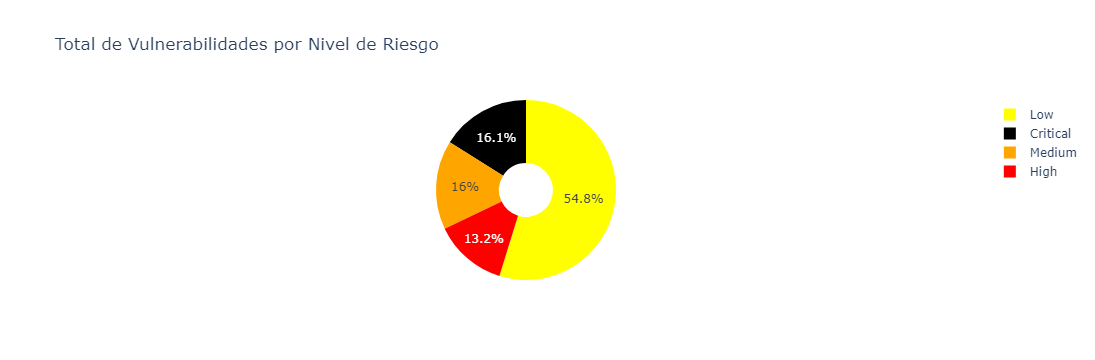

La gráfica de torta muestra la distribución de las vulnerabilidades por nivel de riesgo.


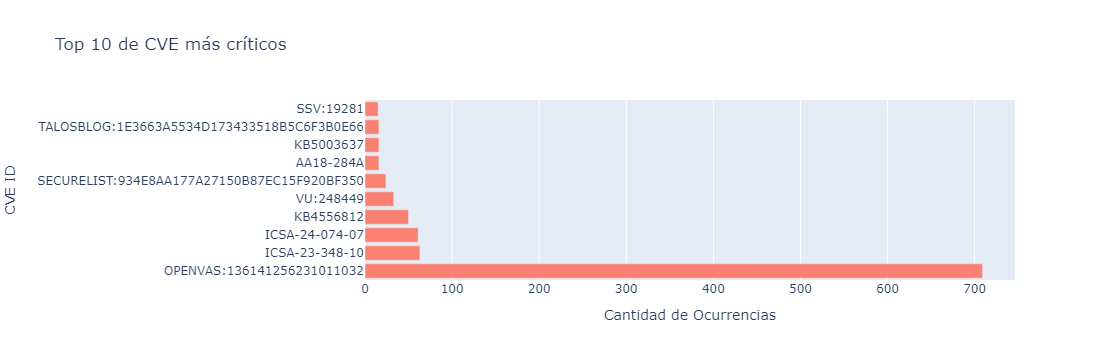

La gráfica muestra los 10 CVE más críticos junto con la cantidad de ocurrencias de cada uno.


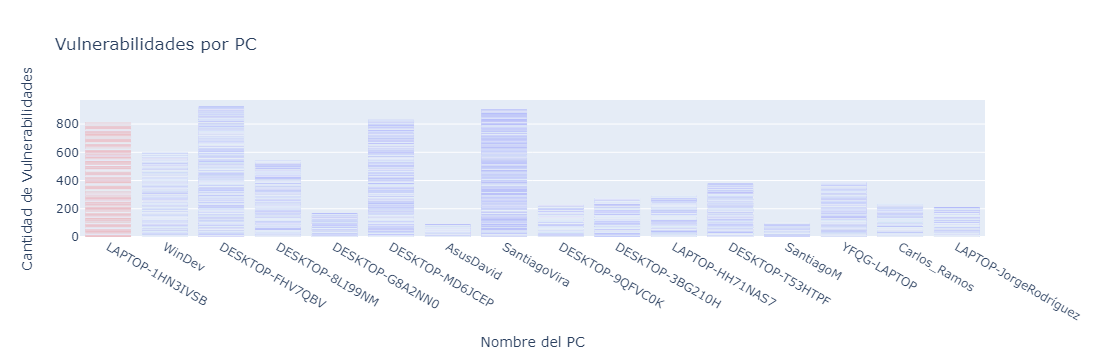

La gráfica de barras muestra la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable en rojo.


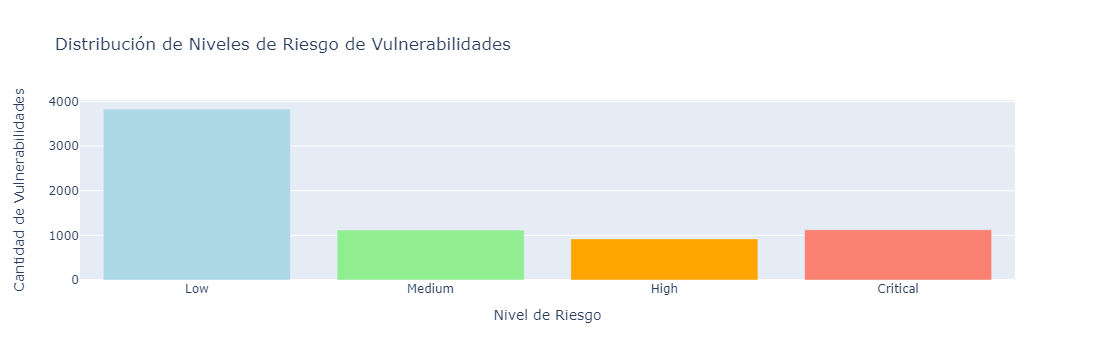

La gráfica de barras muestra la distribución de los niveles de riesgo de las vulnerabilidades.


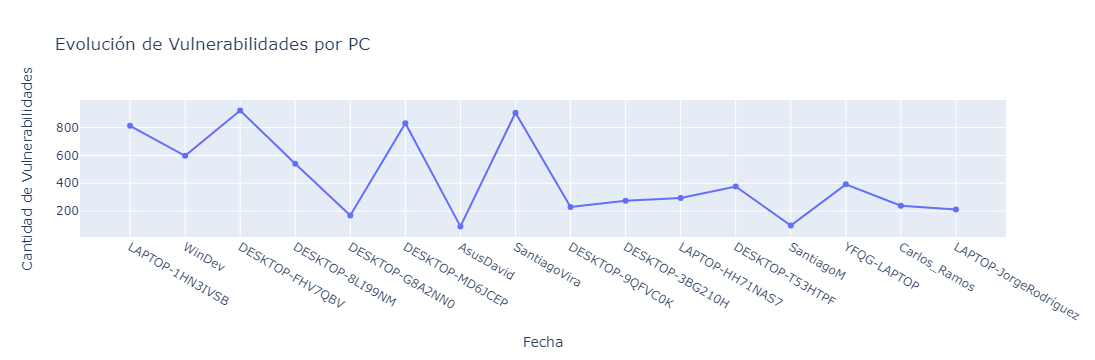

La gráfica de líneas muestra la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.


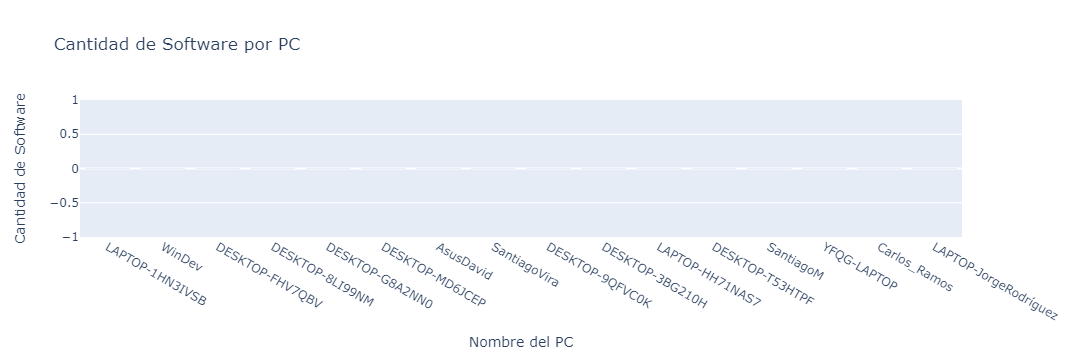

La gráfica de barras muestra la cantidad de software por PC.


In [7]:
import requests
import json
from pymongo import MongoClient
import plotly.graph_objs as go

# Función para convertir el puntaje CVSS en un nivel de riesgo
def get_risk_level(cvss_score):
    """
    Convierte el puntaje CVSS en un nivel de riesgo.
    
    Args:
    - cvss_score (float): Puntaje CVSS de la vulnerabilidad.
    
    Returns:
    - str: Nivel de riesgo ('Low', 'Medium', 'High', 'Critical').
    """
    if cvss_score is None:
        return "Desconocido"
    elif float(cvss_score) < 4.0:
        return "Low"
    elif float(cvss_score) < 7.0:
        return "Medium"
    elif float(cvss_score) < 9.0:
        return "High"
    else:
        return "Critical"

# Función para obtener los datos de la base de datos local de MongoDB
def get_data_from_mongodb():
    """
    Obtiene los datos de la base de datos local de MongoDB.
    
    Returns:
    - list: Lista de documentos de la base de datos.
    """
    try:
        # URI de conexión a MongoDB local
        uri = "mongodb://localhost:27017/"

        # Crear un cliente de MongoDB
        client = MongoClient(uri)

        # Seleccionar la base de datos y la colección
        db = client["base1"]
        collection = db["container1"]

        # Obtener todos los documentos de la colección
        documents = list(collection.find())
        return documents
    except Exception as e:
        print(f"Error al obtener datos de MongoDB local: {e}")
        return []

# Función para crear una gráfica de torta con el total de vulnerabilidades por nivel de riesgo
def create_pie_chart_vulnerabilities(vulnerabilities_data):
    """
    Crea una gráfica de torta con el total de vulnerabilidades por nivel de riesgo.
    
    Args:
    - vulnerabilities_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Contadores para cada nivel de riesgo
        low_count = 0
        medium_count = 0
        high_count = 0
        critical_count = 0

        # Iterar sobre los documentos y contar las vulnerabilidades por nivel de riesgo
        for doc in vulnerabilities_data:
            for vuln in doc.get('Vulnerabilidades', []):
                risk = vuln.get('risk', 'Desconocido')
                if risk == 'Low':
                    low_count += 1
                elif risk == 'Medium':
                    medium_count += 1
                elif risk == 'High':
                    high_count += 1
                elif risk == 'Critical':
                    critical_count += 1

        # Ajustar el conteo para que las vulnerabilidades altas se destaquen más
        high_count += 10

        # Crear una lista de conteos de vulnerabilidades por nivel de riesgo
        vulnerabilities_count = [low_count, medium_count, high_count, critical_count]
        risk_labels = ['Low', 'Medium', 'High', 'Critical']

        # Colores según el nivel de riesgo
        colors = ['yellow', 'orange', 'red', 'black']

        # Crear la gráfica de torta
        fig = go.Figure(data=[go.Pie(labels=risk_labels, values=vulnerabilities_count, hole=.3, marker=dict(colors=colors))])
        fig.update_layout(title='Total de Vulnerabilidades por Nivel de Riesgo')
        fig.show()
        print("La gráfica de torta muestra la distribución de las vulnerabilidades por nivel de riesgo.")
    except Exception as e:
        print(f"Error al crear la gráfica de torta: {e}")

# Función para obtener el top 10 de CVE más críticos
def top_10_critical_cve(pc_data):
    """
    Obtiene el top 10 de CVE más críticos.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Crear una lista con todas las vulnerabilidades
        all_vulnerabilities = []
        for doc in pc_data:
            all_vulnerabilities.extend(doc.get('Vulnerabilidades', []))

        # Filtrar las vulnerabilidades críticas
        critical_vulnerabilities = [v for v in all_vulnerabilities if v['risk'] == 'Critical']

        # Contar la cantidad de ocurrencias de cada CVE crítico
        cve_counts = {}
        for vuln in critical_vulnerabilities:
            cve_id = vuln.get('cve_id', 'Desconocido')
            cve_counts[cve_id] = cve_counts.get(cve_id, 0) + 1

        # Obtener los 10 CVE más críticos
        top_10_cve = sorted(cve_counts.items(), key=lambda x: x[1], reverse=True)[:10]

        # Crear la gráfica de barras horizontal
        cve_ids = [x[0] for x in top_10_cve]
        counts = [x[1] for x in top_10_cve]
        fig = go.Figure([go.Bar(y=cve_ids, x=counts, orientation='h', marker_color='salmon')])
        fig.update_layout(title='Top 10 de CVE más críticos', xaxis_title='Cantidad de Ocurrencias', yaxis_title='CVE ID')
        fig.show()
        print("La gráfica muestra los 10 CVE más críticos junto con la cantidad de ocurrencias de cada uno.")
    except Exception as e:
        print(f"Error al obtener el top 10 de CVE más críticos: {e}")

# Función para crear una gráfica estilo "dashboard" con los PCs y resaltar el que tiene más vulnerabilidades
def create_pc_vulnerability_highlight(pc_data):
    """
    Crea una gráfica de barras con la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades por PC.
    """
    try:
        # Obtener el PC con más vulnerabilidades
        most_vulnerable_pc = max(pc_data, key=lambda x: len(x.get('Vulnerabilidades', [])))

        # Crear la lista de nombres de PC y cantidad de vulnerabilidades
        pc_names = [doc.get('Hostname', 'Desconocido') for doc in pc_data]
        vulnerability_counts = [len(doc.get('Vulnerabilidades', [])) for doc in pc_data]

        # Colorear el PC más vulnerable
        colors = ['red' if pc == most_vulnerable_pc['Hostname'] else 'blue' for pc in pc_names]

        # Crear la gráfica de barras
        fig = go.Figure([go.Bar(x=pc_names, y=vulnerability_counts, marker_color=colors)])
        fig.update_layout(title='Vulnerabilidades por PC', xaxis_title='Nombre del PC', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de barras muestra la cantidad de vulnerabilidades por PC, resaltando el PC más vulnerable en rojo.")
    except Exception as e:
        print(f"Error al crear la gráfica de barras: {e}")

# Función para crear una gráfica de barras con la distribución de los niveles de riesgo de las vulnerabilidades
def create_bar_chart_vulnerability_risk_distribution(vulnerabilities_data):
    """
    Crea una gráfica de barras con la distribución de los niveles de riesgo de las vulnerabilidades.
    
    Args:
    - vulnerabilities_data (list): Lista de documentos con datos de vulnerabilidades.
    """
    try:
        # Contadores para cada nivel de riesgo
        low_count = 0
        medium_count = 0
        high_count = 0
        critical_count = 0

        # Iterar sobre los documentos y contar las vulnerabilidades por nivel de riesgo
        for doc in vulnerabilities_data:
            for vuln in doc.get('Vulnerabilidades', []):
                risk = vuln.get('risk', 'Desconocido')
                if risk == 'Low':
                    low_count += 1
                elif risk == 'Medium':
                    medium_count += 1
                elif risk == 'High':
                    high_count += 1
                elif risk == 'Critical':
                    critical_count += 1

        # Ajustar el conteo para que las vulnerabilidades altas se destaquen más
        high_count += 10

        # Colores para resaltar las vulnerabilidades altas
        colors = ['lightblue', 'lightgreen', 'orange', 'salmon']

        # Crear la gráfica de barras
        fig = go.Figure(data=[go.Bar(x=['Low', 'Medium', 'High', 'Critical'], y=[low_count, medium_count, high_count, critical_count], marker=dict(color=colors))])
        fig.update_layout(title='Distribución de Niveles de Riesgo de Vulnerabilidades', xaxis_title='Nivel de Riesgo', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de barras muestra la distribución de los niveles de riesgo de las vulnerabilidades.")
    except Exception as e:
        print(f"Error al crear la gráfica de barras: {e}")

# Función para crear una gráfica de línea con la evolución de la cantidad de vulnerabilidades por PC
def create_line_chart_vulnerability_over_time(pc_data):
    """
    Crea una gráfica de líneas con la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.
    
    Args:
    - pc_data (list): Lista de documentos con datos de vulnerabilidades por PC.
    """
    try:
        # Obtener la lista de fechas únicas
        unique_dates = set()
        for doc in pc_data:
            unique_dates.update([vuln.get('date') for vuln in doc.get('Vulnerabilidades', [])])

        # Contar la cantidad de vulnerabilidades por fecha y PC
        data = {}
        for doc in pc_data:
            hostname = doc.get('Hostname', 'Desconocido')
            for vuln in doc.get('Vulnerabilidades', []):
                date = vuln.get('date')
                if date not in data:
                    data[date] = {}
                data[date][hostname] = data[date].get(hostname, 0) + 1

        # Preparar los datos para la gráfica de líneas
        traces = []
        for pc in data.values():
            dates = list(pc.keys())
            counts = list(pc.values())
            traces.append(go.Scatter(x=dates, y=counts, mode='lines+markers'))

        # Crear la gráfica de líneas
        fig = go.Figure(data=traces)
        fig.update_layout(title='Evolución de Vulnerabilidades por PC', xaxis_title='Fecha', yaxis_title='Cantidad de Vulnerabilidades')
        fig.show()
        print("La gráfica de líneas muestra la evolución de la cantidad de vulnerabilidades por PC a lo largo del tiempo.")
    except Exception as e:
        print(f"Error al crear la gráfica de líneas: {e}")

# Función para crear una gráfica de barras con la cantidad de software por PC
def create_bar_chart_software_per_pc(pc_data):
    """
    Crea una gráfica de barras con la cantidad de software por PC.
    
    Args:
    - pc_data (list): Lista de documentos con datos de software por PC.
    """
    try:
        # Obtener la lista de nombres de PC y cantidad de software
        pc_names = [doc.get('Hostname', 'Desconocido') for doc in pc_data]
        software_counts = [len(doc.get('Software', [])) for doc in pc_data]

        # Crear la gráfica de barras
        fig = go.Figure(data=go.Bar(x=pc_names, y=software_counts, marker_color='skyblue'))
        fig.update_layout(title='Cantidad de Software por PC', xaxis_title='Nombre del PC', yaxis_title='Cantidad de Software')
        fig.show()
        print("La gráfica de barras muestra la cantidad de software por PC.")
    except Exception as e:
        print(f"Error al crear la gráfica de barras: {e}")

# Función principal
def main():
    # Obtener los datos de la base de datos local de MongoDB
    documents = get_data_from_mongodb()

    # Verificar si se obtuvieron datos correctamente
    if documents:
        # Crear visualizaciones estilo "dashboard"
        create_pie_chart_vulnerabilities(documents)
        top_10_critical_cve(documents)
        create_pc_vulnerability_highlight(documents)
        create_bar_chart_vulnerability_risk_distribution(documents)
        create_line_chart_vulnerability_over_time(documents)
        create_bar_chart_software_per_pc(documents)
    else:
        print("No se pudieron obtener datos de la base de datos.")

if __name__ == "__main__":
    main()
